# Titanic Passenger Survival Analysis
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we'll try to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (i.e. name, age, gender, socio-economic class, etc). 

Competition Page:
https://www.kaggle.com/c/titanic

In [ ]:
# Import various libraries/packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

First, let's read in our data and see what we'll be working with.

In [ ]:
titanic_train = pd.read_csv('../input/titanic/train.csv')
titanic_test = pd.read_csv('../input/titanic/test.csv')

titanic_train.head()

When I checked the data dictionary on the competition page, I found the following column definitions: 
* survival：Whether or not the passenger survived, 0 = No, 1 = Yes
* pclass：Passenger class, with higher passenger classes representing higher socioeconomic status, 1 = 1st, 2 = 2nd, 3 = 3rd
* sex：Gender
* Age：Age
* sibsp：Number of siblings/spouses onboard the Titanic
* parch：Number of parents/children onboard the Titanic
* ticket：Ticket number
* fare：Ticket fare
* cabin：Room number
* embarked：Port of departure, C = Cherbourg, Q = Queenstown, S = Southampton

Next, let's check the distribution of each variable.

In [ ]:
titanic_train.describe()

In [ ]:
titanic_test.describe()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,14))
sns.set_theme()
sns.color_palette()

sns.histplot(titanic_train['Age'], ax=axes[0,0], color='green')
sns.histplot(titanic_train['Fare'], ax=axes[0,1])
sns.histplot(titanic_train['SibSp'], ax=axes[1,0], color='red')
sns.histplot(titanic_train['Parch'], ax=axes[1,1], color='orange')
sns.histplot(titanic_train['Pclass'], ax=axes[2,0], color='purple')
sns.histplot(titanic_train['Sex'], ax=axes[2,1], color='gray')

It seems that most passengers were between 20-40 years old, and that there were about twice as many men as women. We can also see there were a few passengers with a very high ticket fare.

In [ ]:
titanic_train['Survived'].value_counts().plot.bar()

It looks like more passengers died than survived.

## I. Preprocessing
Before using our data in a machine learning model, we have to process it into a format that can be understood by the model.
In this analysis this will mainly consist of 3 steps:

1. Dealing with missing values
2. Dealing with categorical values
3. Standardizing/Normalizing the data

### 1．Dealing with Missing Values
Machine learning models are unable to use data with missing values, so if our data contains any we will have to deal with them.

First, let's see if our data has any missing values.

In [ ]:
print("Train:")
print(titanic_train.isnull().sum())
print()
print("Test:")
print(titanic_test.isnull().sum())

It looks like both Train and Test have quite a few missing values for the Age and Cabin columns. We can also see that Train's Embarked column has 2 missing values, and Test's Fare column has 1 missing value.

There are several ways to deal with missing values, but often the 2 methods below are used:
1. Remove columns/rows with missing values
2. Replace missing values with a substitute value

If we remove rows/columns that contain missing values, we also lose all the other data contained in that column/row, so it is usually preferable to impute a replacement value instead of removing the row/column entirely.

There are many options for replacement values, including the mean, mode, median, and even values predicted from a model.

For this analysis I decided to drop the Cabin column, since over 75% of the values are missing. For categorical variables I chose to impute the mode for the column, and for numerical columns the mean.

In [ ]:
titanic_train['Age'] = titanic_train['Age'].fillna(titanic_train['Age'].mean())
titanic_test['Age'] = titanic_test['Age'].fillna(titanic_test['Age'].mean())

titanic_train['Embarked'] = titanic_train['Embarked'].fillna(titanic_train['Embarked'].mode()[0])
titanic_test['Fare'] = titanic_test['Fare'].fillna(titanic_test['Fare'].mean())

titanic_train.drop(columns=['Cabin'], inplace=True)
titanic_test.drop(columns=['Cabin'], inplace=True)

In [ ]:
print("Train:")
print(titanic_train.isnull().sum())
print()
print("Test:")
print(titanic_test.isnull().sum())

It looks like we got rid of all the missing values. Now let's move on to processing the categorical variables.

### 2．Processing Categorical Variables
For people, when we see words like "Male", we are able to use our general knowledge and experience to infer the meaning. For a machine learning model however, it is unable to infer meaning or assign value to categorical variables like male, so it is necessary to convert it to a format that it can interpret.
Two frequently used methods for this are:

1. One-hot encoding
2. Ordinal encoding

One-hot encoding creates a new column for each unique value in the target column, with the values of the new column being either 0 or 1. For example, using one-hot encoding on the "sex" column would give us two new columns, sex_male and sex_female, with female passengers having a value of 1 in the sex_female column and a 0 in the sex_male column.

Ordinal encoding is a method useful when the values in a column have an order or rank. This method doesn't increase the number of columns, but replaces the values of the target column with ordered values. We could use this method on the "Pclass" column, since we can say Pclass 1 is higher or "better" than Pclass 2 and 3. We could convert the values to Pclass 3 = 0, Pclass 2 = 1, Pclass 1 = 2, to indicate their order.

Categorical variables are not limited to just text data though; we can also convert numerical data to categorical data.

For our current data, a good example of where this might be useful is the "Age" column. It's easy to imagine how passengers might be treated differently based on their age category (i.e. child) rather than the actual number of their age, so this seems like a good candidate for conversion to a categorical variable.

Let's plot the relationship between survival and age to check this theory.

In [ ]:
sns.displot(data=titanic_train, x='Age', hue='Survived')

Based on the graph above, it seems that children were much more likely to survive than other age groups.
Now that we have confirmed this relationship between survival and age, it seems that age will better explain survival as a categorical variable instead of a numeric one.

Let's create a new column with 6 age categories.

In [ ]:
# Create age categories
label_names = ['Infant', 'Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
cut_points =  [0, 5, 12, 18, 35, 60, 100]

titanic_train['Age_category'] = pd.cut(titanic_train['Age'], cut_points, labels=label_names)
titanic_test['Age_category'] = pd.cut(titanic_test['Age'], cut_points, labels=label_names)

In [ ]:
age_cats = titanic_train.pivot_table(index='Age_category', values='Survived')
age_cats.plot.bar()

Now let's create dummy columns for our categorical data with one-hot encoding.

In [ ]:
# Create dummy columns
def create_dummies(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix = column_name)
    df = pd.concat([df, dummies], axis=1)
    return df
    
titanic_train = create_dummies(titanic_train, 'Sex')
titanic_test = create_dummies(titanic_test, 'Sex')

titanic_train = create_dummies(titanic_train, 'Age_category')
titanic_test = create_dummies(titanic_test, 'Age_category')

titanic_train = create_dummies(titanic_train, 'Pclass')
titanic_test = create_dummies(titanic_test, 'Pclass')

In [ ]:
titanic_train.iloc[:, 11:].head()

### 3．Standardizing/Normalizing Data
Our final step in preprocessing is to standardize/normalize our numerical data.

When we look at numerical data, we have a rough understanding of how high or low a value is based on our knowledge of the units the data is in. For example, we know that 20 years old is not a particularly high value, but 20 siblings would be considered very high. For a machine learning model to be able to interpret this and not overemphasize high values, it is necessary to scale our data. Two frequently used mehtods for this are Standardization and Normalization.

To normalizing data, we convert the data to a scale where the maximum value is 1 and the minimum value is 0.
To standardize data, we transform the data to have a distribution with a mean of 0 and a standard deviation of 1.

Depending on several factors, such as the distribution of your data and the models being used, the appropriate method to use can vary.

In many cases it is approptiate to use standardization, but for this analysis I decided to use normalization since the data contains several variables that do not follow a normal distribution.

In [ ]:
from sklearn.preprocessing import minmax_scale

for col in ['SibSp', 'Parch', 'Fare']:
    titanic_train[col + '_scaled'] = minmax_scale(titanic_train[col])
    titanic_test[col + '_scaled'] = minmax_scale(titanic_test[col])

In [ ]:
titanic_train.iloc[:, 11:].head()

## II. Model Creation and Validation
When creating and validating a model, there are 3 main steps：
1. Create an initial model and calculate a baseline score
2. Perform feature engineering as necessary
3. Tune model hyperparameters

However, it is important to note that this is an iterative process, and it is necessary to re-calculate the model's score at various stages to compare with the baseline.

We will be using accuracy as a validation metric, which is the percent of values that were predicted correctly by the model.

We will also use a method called cross-validation to help us test our model.
When validating a model, we first use one part of the data to train the model, and then we use the rest of the data to test the model. However, it's possible that the selection of data used for either training or testing contains sample bias, which would lead to us creating a sub-optimal model.

To prevent this, we can perform validation several times, each time using a different portion of the data for training and testing, and take an average of the scores to get a better idea of how our model is actually performing. This method is known as cross-validation, and can help us to create better models.

In this analysis our goal is to predict whether a passenger survived or not, so it is a classification problem.

There are many models we can use for classification, but first let's calculate a baseline score using a logistic regression model.

### 1. Initial Model Creation/Baseline Accuracy Calculation

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(random_state=1)

columns = ['Age_category_Infant',
       'Age_category_Child', 'Age_category_Teenager',
       'Age_category_Young Adult', 'Age_category_Adult',
       'Age_category_Senior', 'Fare_scaled', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male','SibSp_scaled', 'Parch_scaled']

scores = cross_val_score(lr, titanic_train[columns], titanic_train['Survived'], cv=10, scoring='accuracy')
print(np.mean(scores))

80%! Not bad for our first try!

However, similar to linear regression, logistic regression is a very accurate model when the predictor variables and the target variable have a linear relationship, but the model's accuracy suffers when this is not the case.

Let's try the tree-based Random Forest Classifier and Xgboost Classifier and see how they compare.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1)

scores = cross_val_score(rf, titanic_train[columns], titanic_train['Survived'], cv=10, scoring='accuracy')
print(np.mean(scores))

In [ ]:
import xgboost as xgb

xgboost = xgb.XGBClassifier(random_state=1, verbosity=0, use_label_encoder=False)

scores = cross_val_score(xgboost, titanic_train[columns], titanic_train['Survived'], cv=10, scoring='accuracy')
print(np.mean(scores))

It looks like Xgboost Classifier has the best score out of all of the models.

We'll use Xgboost going forward, and consider our baseline to be .8137.

### 2. Feature Engineering
We've created our initial model and calculated a baseline accuracy score.
But if we want to create an even better model, we need to reduce our variables to the ones that best predict survival, and reduce the noise in our model.

In order to do this, first let's take a look at the coefficients from the logistic regression model we used previously to get an idea of the predictive power of each variable.

In [ ]:
columns = ['Age_category_Infant',
       'Age_category_Child', 'Age_category_Teenager',
       'Age_category_Young Adult', 'Age_category_Adult',
       'Age_category_Senior', 'Fare_scaled', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male','SibSp_scaled', 'Parch_scaled']

lr = LogisticRegression()
lr.fit(titanic_train[columns], titanic_train['Survived'])
coefficients = lr.coef_
feature_importance = pd.Series(coefficients[0], index=columns)
feature_importance.plot.barh()

After looking at the coefficients, it seems that being male, the number of family members onboard, low passenger class, and being an adult are associated with not surviving, while being female, high passenger class, high ticket fare, and being a child are associated with survival.

Looking closely at the results, it seems that some phenomena are being explained by the same variable. SipSp and Parch seem to represent family size, and Fare_scaled and Pclass_1 seem to be explaining the socioeconomic status of the passenger.

Let's check the correlation of the variables to see if this is happening.

In [ ]:
correlations = titanic_train[columns].corr()
sns.set(style='white')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11,9))
sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

As suspected, it looks like SipSp and Parch, as well asnFare_scaled and Pclass_1 are positively correlated.

When we looked at the coefficients from the logistic regression model, variables related to family size had relatively large coefficients, but what about passengers who were alone?

Let's add a variable to our data for passengers who were alone, and see how this affects our accuracy score.

In [ ]:
def process_isalone(df):
    df['family_size'] = df[['SibSp', 'Parch']].sum(axis=1)
    df['isalone'] = 0
    df.loc[(df['family_size'] == 0), 'isalone'] = 1
    df = df.drop('family_size', axis=1)
    return df

titanic_train = process_isalone(titanic_train)
titanic_test = process_isalone(titanic_test)

In [ ]:
columns.append('isalone')

scores = cross_val_score(xgboost, titanic_train[columns], titanic_train['Survived'], cv=10, scoring='accuracy')
print(np.mean(scores))

We were able to raise our model's score with the addition of isalone.

We can continue to manually add and remove variables, but this isn't very efficient. Scikit-learn's feature_selection module includes recursive feature elimination, a method that iteratively removes the variables with the least explanatory power until an optimal score is reached.

Let's apply this to our data and see if it improves our score.

In [ ]:
from sklearn.feature_selection import RFECV

def select_features(df, clf):
    df = df.select_dtypes([np.number])
    all_x = df.drop(['PassengerId', 'Survived'], axis=1)
    all_y = df['Survived']
    
    selector = RFECV(clf, min_features_to_select=5, cv=10, scoring='accuracy')
    selector.fit(all_x, all_y)
    
    best_columns = list(all_x.columns[selector.support_])
    return best_columns

select_features(titanic_train.drop(columns=['Pclass', 'Age', 'Fare', 'SibSp', 'Parch']), xgboost)

After using recursive feature elimination, it seems that the combination of the above columns resulted in the best scoring model.

Let's confirm this with cross-validation.

In [ ]:
new_cols = ['Sex_female',
 'Age_category_Infant',
 'Age_category_Child',
 'Age_category_Senior',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'SibSp_scaled',
 'Fare_scaled']

scores = cross_val_score(xgboost, titanic_train[new_cols], titanic_train['Survived'], cv=10, scoring='accuracy')
print(np.mean(scores))

We were able to increase the score by 1.6%! The isalone column that we previously added isn't included, but for now we'll continue with the new columns.

## 3. Hyperparameter Tuning
Up until now we have mostly used feature selection and feature engineering to improve our model's score, but we can also achieve this by changing the settings (hyperparameters) of our model.

Hyperparameters vary depending on the model being used, and our current model, Xgboost Classifier, has quite a few hyperparameters that can be adjusted. We will focus on adjusting n_estimators, learning_rate, max_depth for simplicity.

* n_estimators: The number of Decision Trees to be used in our model
* learning_rate: A weighting factor for the corrections by new trees when added to the model
* max_depth: The maximum depth for each Decision Tree

Also, to avoid overfitting our model to the training data, we will employ early stopping. Early stopping is a method that stops the training of the model when the accuracy score begins to drop in succession.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(titanic_train[new_cols], 
                                                      titanic_train['Survived'], 
                                                      test_size=.20, 
                                                      random_state=1)

xgboost = xgb.XGBClassifier(random_state=1, 
                            n_estimators = 1000, 
                            learning_rate = .05,
                            max_depth = 4,
                            verbosity = 0, 
                            use_label_encoder = False)

xgboost.fit(x_train, y_train, 
            early_stopping_rounds = 5, 
            eval_metric = 'error', 
            eval_set = [[x_valid, y_valid]], verbose=0)

scores = cross_val_score(xgboost, titanic_train[new_cols], titanic_train['Survived'], cv=10, scoring='accuracy')
print(np.mean(scores))

We will take advantage of Grid Search for our hyperparameter tuning.

Grid Search takes a model and several values for hyperparameters of our choosing, and iteratively searches for the combination of hyperparameters that produces the highest score.

Like recursive feature elimination, this is much more efficient that adjusting the hyperparameters manually.

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier(random_state=1, verbosity=0, use_label_encoder=False)
hyperparameters = {
    'n_estimators': [1000],
    'learning_rate': [.25, .05, .1],
    'max_depth': [3, 4, 5, 10]
                   }

fit_params={'early_stopping_rounds':15, 
            'eval_metric': 'error', 
            'eval_set':[[x_valid, y_valid]]}

gs = GridSearchCV(clf, param_grid=hyperparameters, verbose=0, cv=10, scoring='accuracy')
gs.fit(x_train, y_train, **fit_params, verbose=0)

best_params = gs.best_params_
best_score = gs.best_score_

print(best_params) 
print(best_score)

Let's use these hyperparameters and make our first submission.

In [ ]:
xgboost = xgb.XGBClassifier(random_state=1, 
                            n_estimators = 1000, 
                            learning_rate = .25,
                            max_depth = 4,
                            verbosity = 0, 
                            use_label_encoder = False)

xgboost.fit(x_train, y_train, 
            early_stopping_rounds = 5, 
            eval_metric = 'error', 
            eval_set = [[x_valid, y_valid]], verbose=0)


def save_submission(model, cols, filename='titanic_sub.csv'):
    test_data = titanic_test[cols]
    predictions = model.predict(test_data)
    p_ids = titanic_test['PassengerId']
    submission_df = {"PassengerId": p_ids,
                    'Survived': predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv(filename, index=False)
    
save_submission(xgboost, new_cols)

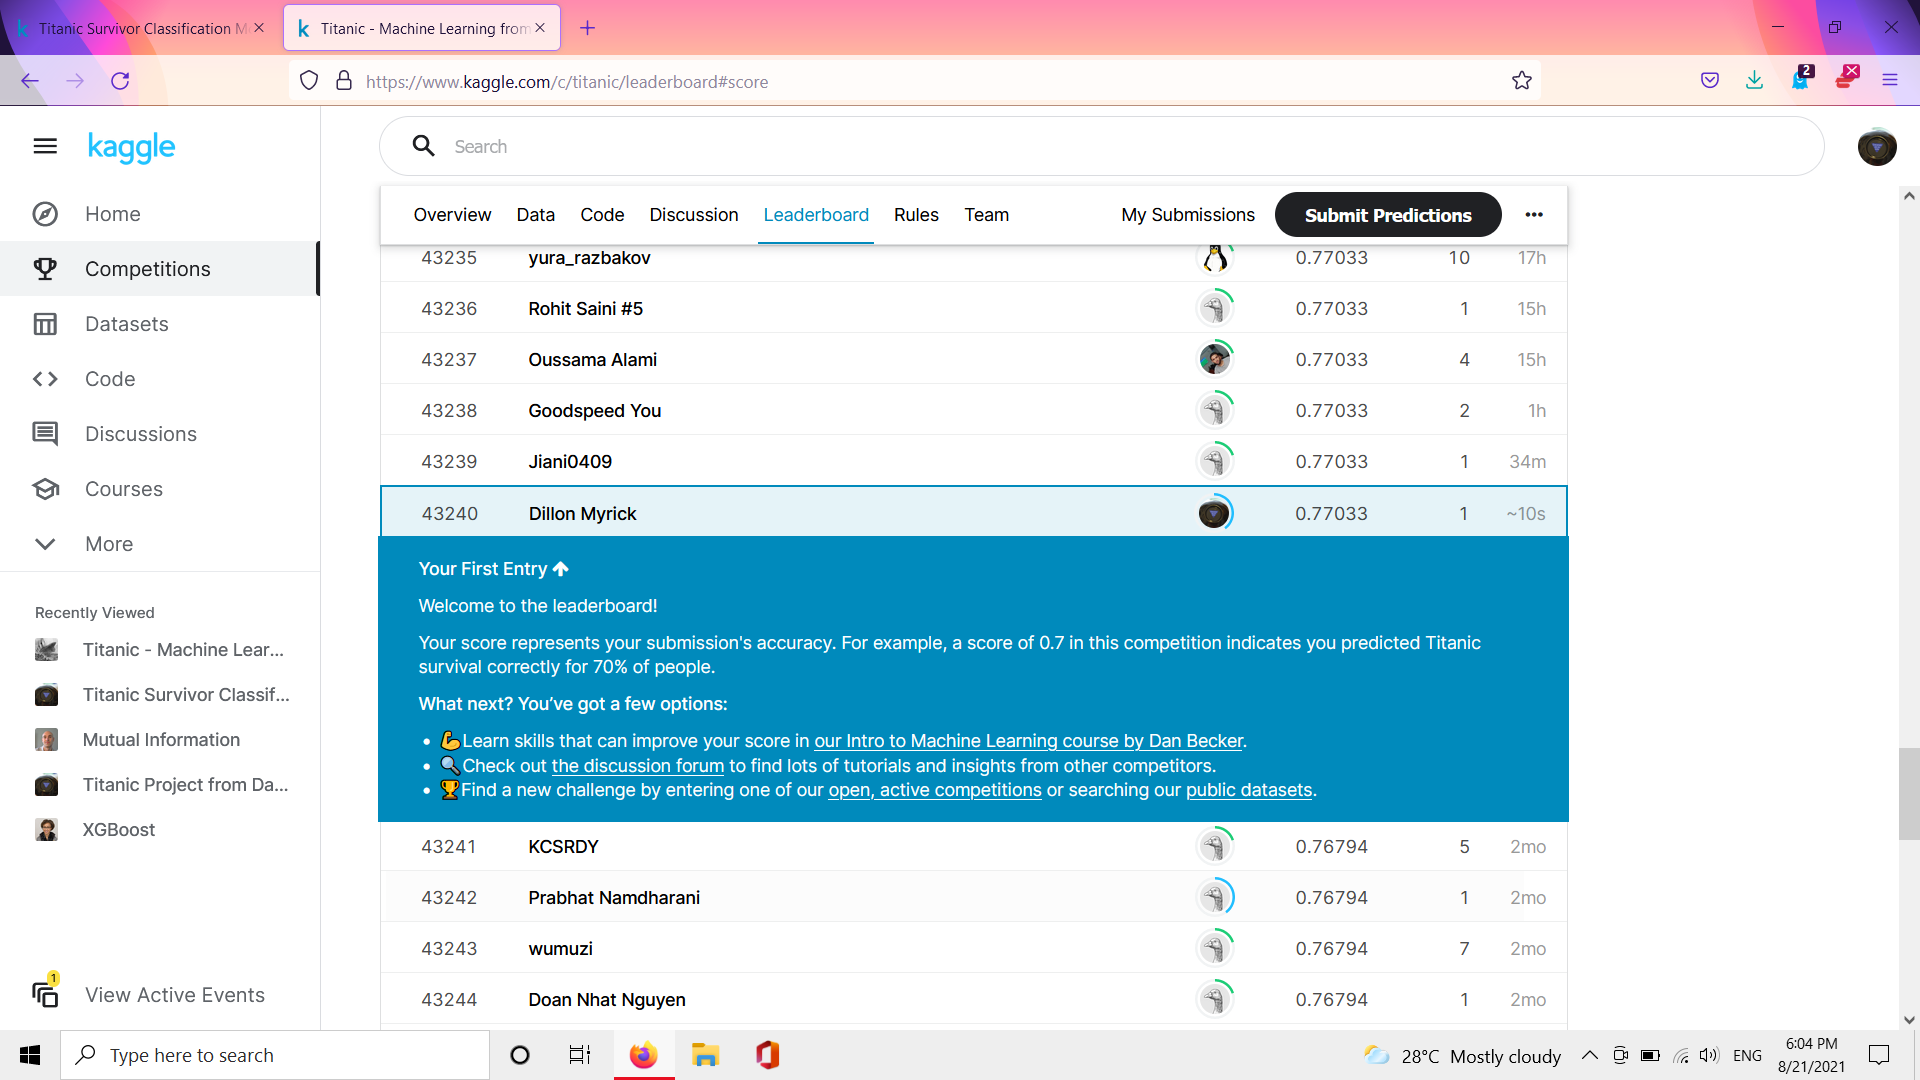

Out of 50,255 entries, we ranked at 43,240. I think we can improve this, so let's continue.

We know that age, gender, and passenger class are good predictors of survival, but currently these variables are all separate columns. What if we combined some of these columns into features like Rich Man or Single Mother?

Let's try and create variables that combine various columns and see if it raises the predictive ability of our model.

In [ ]:
sample = titanic_train.copy()

def create_features(df):
    df['Father'] = 0
    df.loc[(df['Sex_male'] == 1) & (df['Age'] >= 18) & (df['Parch'] >=1), 'Father'] = 1
    
    df['Mother'] = 0
    df.loc[(df['Sex_female'] == 1) & (df['Age'] >= 18) & (df['Parch'] >=1), 'Mother'] = 1
    
    df['single_father'] = 0
    df.loc[(df['Father'] == 1) & (df['SibSp'] == 0), 'single_father'] = 1
    
    df['single_mother'] = 0
    df.loc[(df['Mother'] == 1) & (df['SibSp'] == 0), 'single_mother'] = 1
    
    df['has_SibSp'] = 0
    df.loc[(df['SibSp'] >= 1), 'has_SibSp'] = 1
    
    df['parentless_child'] = 0
    df.loc[(df['Age'] < 18) & (df['Parch'] == 0), 'parentless_child'] = 1
    
    df['childless_man'] = 0
    df.loc[(df['Sex_male'] == 1) & (df['Age'] >= 18) & (df['Parch'] == 0), 'childless_man'] = 1
    
    df['childless_woman'] = 0
    df.loc[(df['Sex_female'] == 1) & (df['Age'] >= 18) & (df['Parch'] == 0), 'childless_woman'] = 1
    
    df['family_size'] = df['SibSp'] + df['Parch']
    df['family_size' + '_scaled'] = minmax_scale(df['family_size'])
    
    df['small_family'] = 0
    df.loc[df['family_size'] <= 2, 'small_family'] = 1
    
    df['average_family'] = 0
    df.loc[(df['family_size'] > 3) & (df['family_size'] < 7), 'average_family'] = 1
    
    df['large_family'] = 0
    df.loc[df['family_size'] >= 7, 'large_family'] = 1
    
    df['Boy'] = 0
    df.loc[(df['Sex_male'] == 1) & (df['Age'] < 18), 'Boy'] = 1
    
    df['Girl'] = 0
    df.loc[(df['Sex_female'] == 1) & (df['Age'] < 18), 'Girl'] = 1
    
    df['Single_man'] = 0
    df.loc[(df['Age'] >= 18) & (df['Sex_male'] == 1) & (df['family_size'] == 0), 'Single_man'] = 1
    
    df['Single_woman'] = 0
    df.loc[(df['Age'] >= 18) & (df['Sex_female'] == 1) & (df['family_size'] == 0), 'Single_woman'] = 1
    
    df['Rich_man'] = 0
    df.loc[(df['Age'] >= 18) & (df['Sex_male'] == 1) & (df['Pclass_1'] == 1), 'Rich_man'] = 1
    
    df['Middle-class_man'] = 0
    df.loc[(df['Age'] >= 18) & (df['Sex_male'] == 1) & (df['Pclass_2'] == 1), 'Middle-class_man'] = 1
    
    df['Poor_man'] = 0
    df.loc[(df['Age'] >= 18) & (df['Sex_male'] == 1) & (df['Pclass_3'] == 1), 'Poor_man'] = 1
    
    df['Rich_woman'] = 0
    df.loc[(df['Age'] >= 18) & (df['Sex_female'] == 1) & (df['Pclass_1'] == 1), 'Rich_woman'] = 1
    
    df['Middle-class_woman'] = 0
    df.loc[(df['Age'] >= 18) & (df['Sex_female'] == 1) & (df['Pclass_2'] == 1), 'Middle-class_woman'] = 1
    
    df['Poor_woman'] = 0
    df.loc[(df['Age'] >= 18) & (df['Sex_female'] == 1) & (df['Pclass_3'] == 1), 'Poor_woman'] = 1
    
    df['Rich_boy'] = 0
    df.loc[(df['Boy'] == 1) & (df['Pclass_1'] == 1), 'Rich_boy'] = 1
    
    df['Middle-class_boy'] = 0
    df.loc[(df['Boy'] == 1) & (df['Pclass_2'] == 1), 'Middle-class_boy'] = 1
    
    df['Poor_boy'] = 0
    df.loc[(df['Boy'] == 1) & (df['Pclass_3'] == 1), 'Poor_boy'] = 1
    
    df['Rich_girl'] = 0
    df.loc[(df['Girl'] == 1) & (df['Pclass_1'] == 1), 'Rich_girl'] = 1
    
    df['Middle-class_girl'] = 0
    df.loc[(df['Girl'] == 1) & (df['Pclass_2'] == 1), 'Middle-class_girl'] = 1
    
    df['Poor_girl'] = 0
    df.loc[(df['Girl'] == 1) & (df['Pclass_3'] == 1), 'Poor_girl'] = 1
    
    df['paid_fare'] = 0
    df.loc[df['Fare'] > 0, 'paid_fare'] = 1
    
    df['low_fare'] = 0
    df.loc[df['Fare'] <= 8, 'low_fare'] = 1
    
    df['average_fare'] = 0
    df.loc[(df['Fare'] > 8) & (df['Fare'] < 31), 'average_fare'] = 1
    
    df['high_fare'] = 0
    df.loc[df['Fare'] >= 31, 'high_fare'] = 1
    
    return df
    
create_features(sample)
sample.head()

In [ ]:
titanic_train = create_features(titanic_train)
titanic_test = create_features(titanic_test)

select_features(titanic_train.drop(columns=['Pclass', 'Age', 'Fare', 'SibSp', 'Parch', 'family_size']), xgboost)

When we run recursive feature elimination again we now have some new columns included.

Let's tune our hyperparameters again with these new columns and make another submission.

In [ ]:
new_cols = select_features(titanic_train.drop(columns=['Pclass', 'Age', 'Fare', 'SibSp', 'Parch', 'family_size']), xgboost)
x_train, x_valid, y_train, y_valid = train_test_split(titanic_train[new_cols], 
                                                      titanic_train['Survived'], 
                                                      test_size=.2, 
                                                      random_state=1)

clf = xgb.XGBClassifier(random_state=1, verbosity=0, use_label_encoder=False)
hyperparameters = {
    'n_estimators': [1000],
    'learning_rate': [.1],
    'max_depth': [2, 3, 4, 8]
                   }

fit_params={'early_stopping_rounds':15, 
            'eval_metric': 'error', 
            'eval_set':[[x_valid, y_valid]]}

gs = GridSearchCV(clf, param_grid=hyperparameters, verbose=0, cv=10)
gs.fit(x_train, y_train, **fit_params, verbose=0)

best_params = gs.best_params_
best_score = gs.best_score_

print(best_params) 
print(best_score)

In [ ]:
xgboost = xgb.XGBClassifier(random_state = 1, 
                            n_estimators = 1000, 
                            learning_rate = .1,
                            verbosity = 0, 
                            use_label_encoder = False,
                            objective = 'binary:logistic',
                            max_depth = 3)


scores = cross_val_score(xgboost, titanic_train[new_cols], titanic_train['Survived'], cv=10, scoring='accuracy')
print(np.mean(scores))

In [ ]:
xgboost.fit(x_train, y_train, 
            early_stopping_rounds = 5, 
            eval_metric = 'error', 
            eval_set = [[x_valid, y_valid]], verbose = 0)

    
save_submission(xgboost, new_cols)

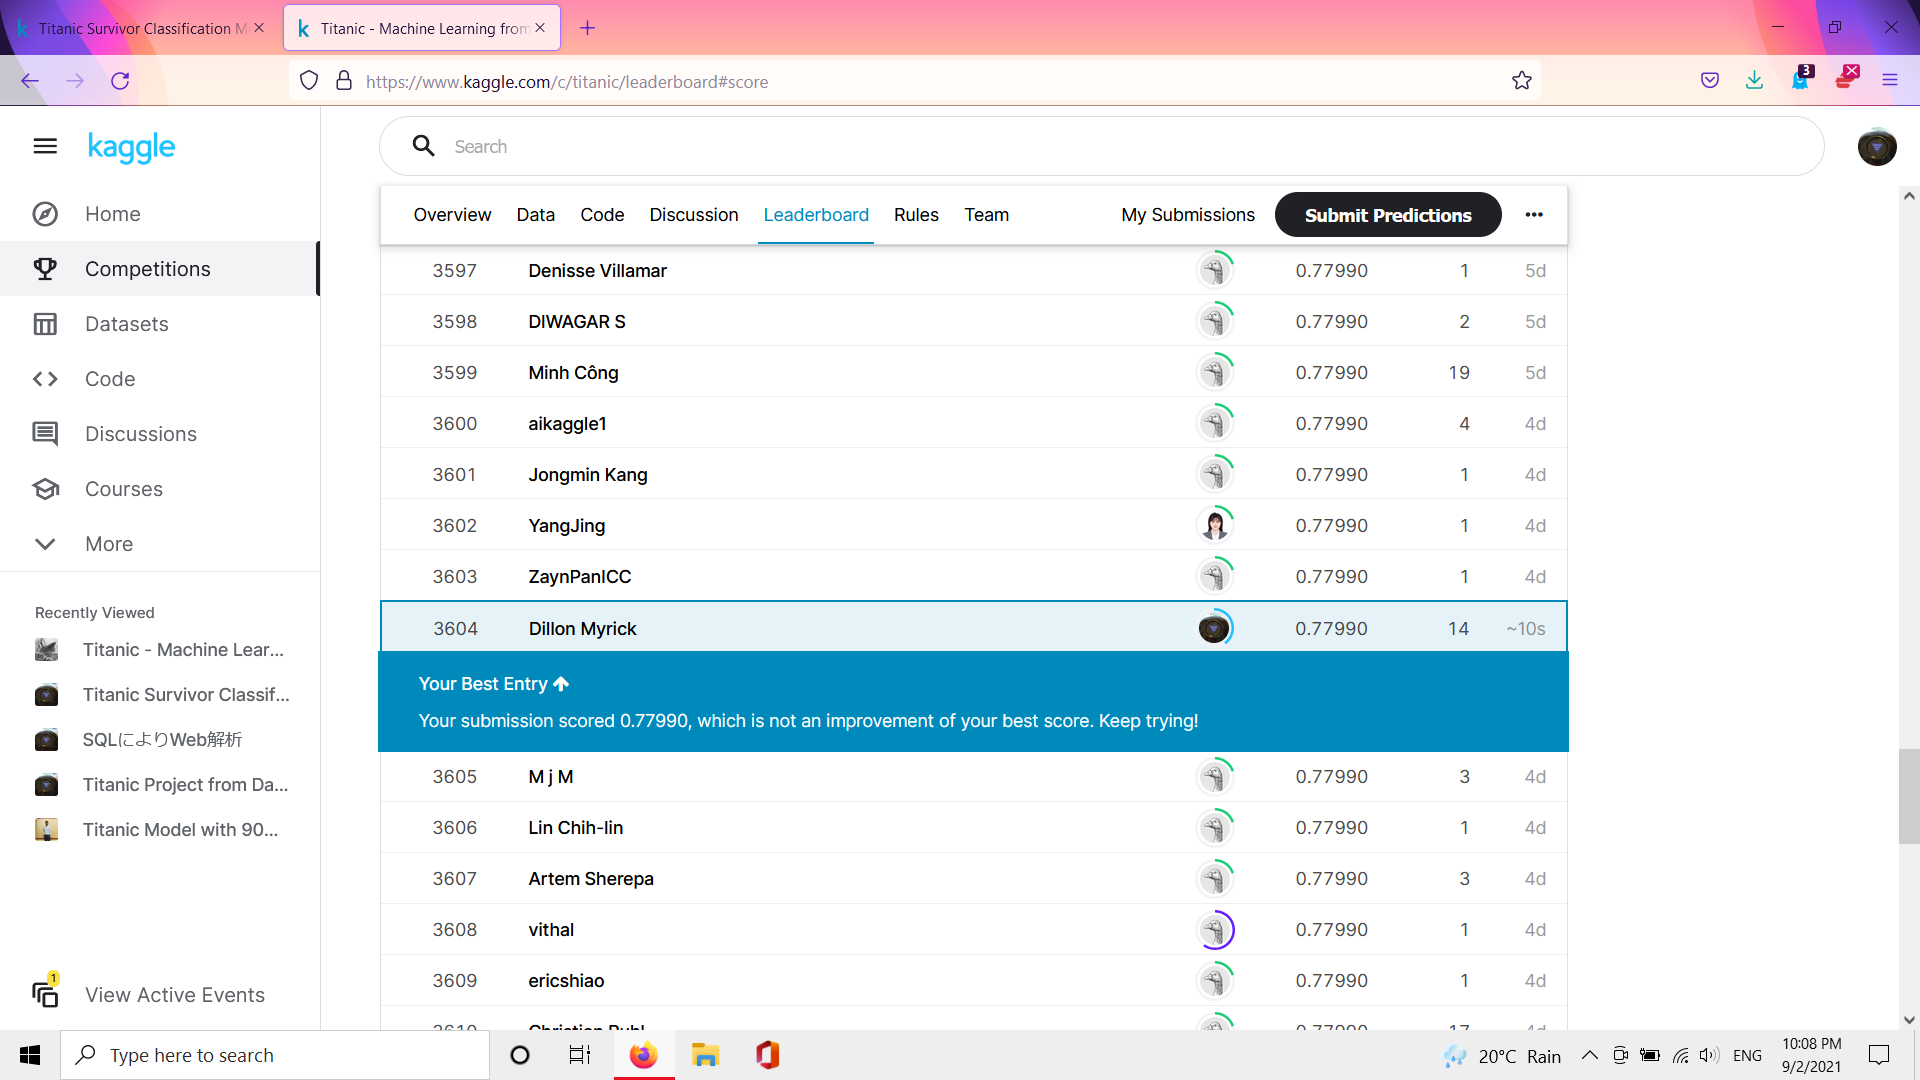

Out of 50,255 entries, we placed at 3,604. This puts our model in the top 8%, not a bad score!

It seems that separating the passengers into smaller groups allowed us to better predict survival with our model.

Thanks for reading!